In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable

start = time.time()
####################################### 5 #######################################

#================================ initialization ================================

#initialization
c = 1
h = 0.08
hx = h
hy = h
Nx = int(16/hx)
Ny = int(8/hy)
ht = 0.00250    #0.99*h/c    0.001584
ep = 10**(-3)

#negative laplacian
def NeLap(hx,hy,Nx,Ny):    
    #create Dx and Dy
    Dx = 1/hx*sp.diags([1, -1], [0, -1], shape=(Nx, Nx-1)).toarray()
    Dy = 1/hy*sp.diags([1, -1], [0, -1], shape=(Ny, Ny-1)).toarray()

    #calculate Axx Ayy
    Lxx =Dx.transpose().dot(Dx)
    Lyy =Dy.transpose().dot(Dy)

    #create Lxx and Lyy
    Ix = sp.eye(Nx-1)
    Iy = sp.eye(Ny-1)

    #compute the sparse 2D Laplacian
    A = sp.kron(Iy,Lxx)+sp.kron(Lyy,Ix)

    #negative laplacian
    A = -A
    return A
A = NeLap(hx,hy,Nx,Ny)

# find the stability upper bound
vals, vecs = la.eigsh(A, k=1, which = 'LM')
print('The upper bound is ', 2/abs(vals[0]))

ht = 2/abs(vals[0])*0.99
Nt = int(40/ht)
u = np.zeros((8,(Nx-1)*(Ny-1)))

print('0.99 upper bound  is', ht*0.99)
print(h**2/4)

The upper bound is  0.001600246760912018
0.99 upper bound  is 0.0015684018503698686
0.0016


In [2]:

# ================================ discretization ===========================
#initial function
def fnut0(x, y):
    u = np.exp(-2*(x-1.5)**2 - 2*(y-1.5)**2)
    return u

#initial conditions
cnt = 0
for j in range(1, Ny):
    for i in range(1, Nx):
        u[0, cnt] = fnut0(i*hx, j*hy)
        cnt+= 1

# k matrix
k = np.zeros((Ny-1, Nx-1))
for j in range(Ny-1):
    for i in range(Nx-1):
        if (i+1)*hx >= 1 and (i+1)*hx<=2 and (j+1)*hy>=1 and (j+1)*hy<=2:
            k[j,i] = 1 
        if (i+1)*hx >= 1 and (i+1)*hx<=3 and (j+1)*hy>=3 and (j+1)*hy<=5: 
            k[j,i] = 1   
        if (i+1)*hy >= 4 and (i+1)*hy<=7 and (j+1)*hx>=4 and (j+1)*hx<=7: 
            k[j,i] = 1  
        if (i+1)*hy >= 9 and (i+1)*hy<=12 and (j+1)*hx>=4 and (j+1)*hx<=6: 
            k[j,i] = 1
        if (i+1)*hy >= 13 and (i+1)*hy<=15 and (j+1)*hx>=1 and (j+1)*hx<=3: 
            k[j,i] = 1

k = k.reshape((Nx-1)*(Ny-1))

#Jacobian
def Jacobian(u):
    diag = sp.diags(u, 0, format = 'csc')    
    J = sp.eye(u.shape[0])  + A - 2*diag
    return J

#f function
def fnf(u):
    f =   u - np.multiply(u,u)
    f =  np.multiply(f,k)
    f = f + A.dot(u)
    return f

J = Jacobian(u[0,:])
print(J.shape)


# function compute vi
def fnvi(ui,u):
    LHS = sp.eye((Nx-1)*(Ny-1)) - ht*Jacobian(ui) 
    RHS = ui - u - ht*fnf(ui)
    RHS = sp.csr_matrix(RHS).transpose()
    vi = la.spsolve(LHS, RHS)
    return vi

(19701, 19701)


In [0]:
#====================================== solver FE =================================
tcnt = 0
cntSol = 1
uTemp0 = u[0,:]
uTemp1 = np.zeros((1,(Nx-1)*(Ny-1)))
for i in range(Nt+1):
    uTemp1 = ht*fnf(uTemp0) + uTemp0
    tcnt+=1
    uTemp0 = uTemp1
     #save wanted solutions
    if abs(tcnt*ht-1) < ht/2:
        u[cntSol,:] = np.copy(uTemp1)
        cntSol += 1
    if abs(tcnt*ht-2) < ht/2:
        u[cntSol,:] = np.copy(uTemp1)
        cntSol += 1
    if abs(tcnt*ht-3) < ht/2:
        u[cntSol,:] = np.copy(uTemp1)
        cntSol += 1
    if abs(tcnt*ht-5) < ht/2:
        u[cntSol,:] = np.copy(uTemp1)
        cntSol += 1
    if abs(tcnt*ht-10) < ht/2:
        u[cntSol,:] = np.copy(uTemp1)
        cntSol += 1
    if abs(tcnt*ht-20) < ht/2:
        u[cntSol,:] = np.copy(uTemp1)
        cntSol += 1
    if abs(tcnt*ht-40) < ht/2:
        u[cntSol,:] = np.copy(uTemp1)
        cntSol += 1

uFE = np.copy(u)
icntFE = tcnt

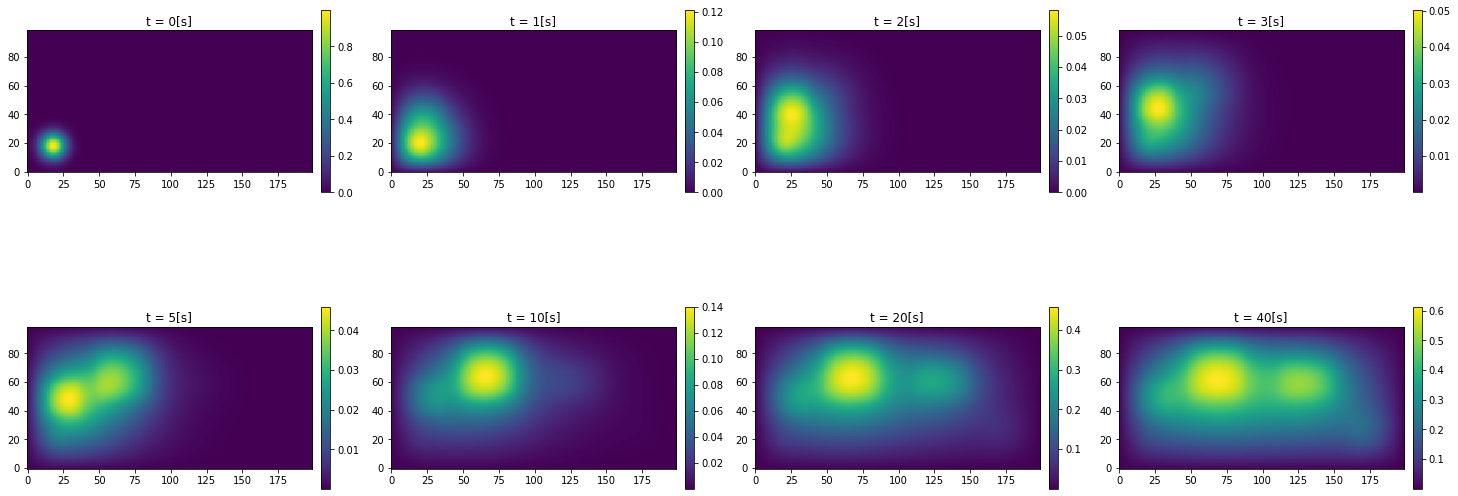

The number of iterations is 25249


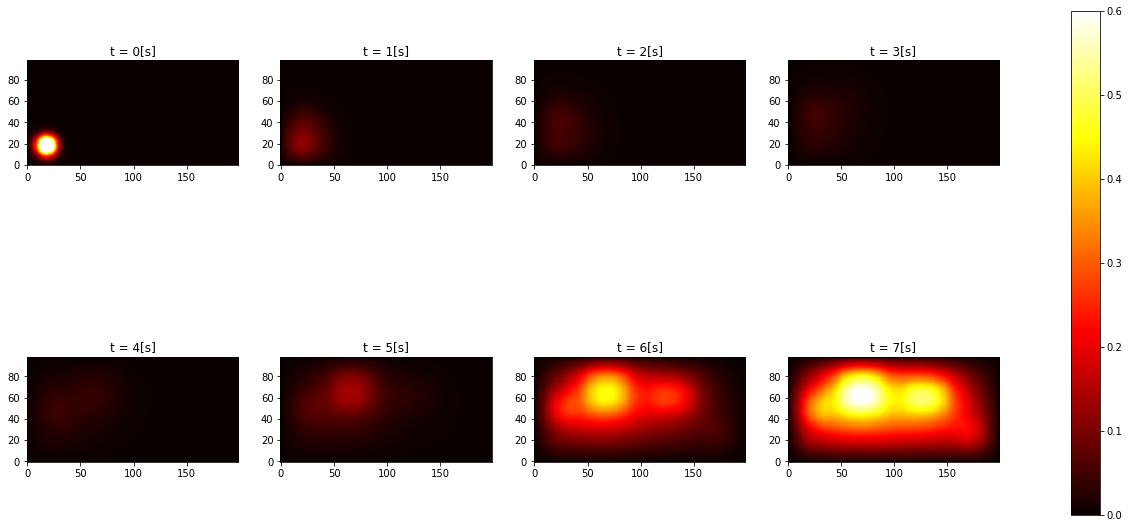

Time costed:  10.105435609817505


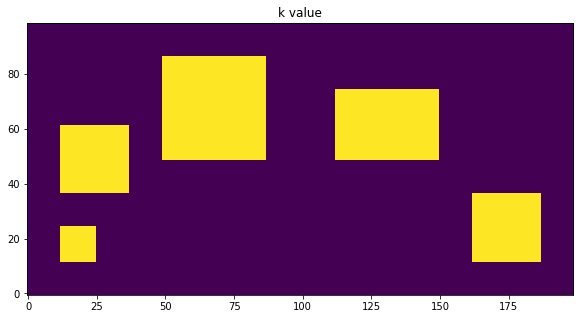

In [4]:
#============================plot the results with color bar======================
#select which method to print
uPrint = uFE
icntPrint = icntFE
# resPrint = resFE

#plot figures
fig, axs = plt.subplots(2, 4,figsize=(25,10))

im1 = axs[0,0].imshow(uPrint[0, :].reshape((Ny-1,Nx-1)))
fig.colorbar(im1, ax=axs[0, 0], fraction=0.03 ,pad = 0.03)
axs[0, 0].set_title("t = 0[s]")
axs[0, 0].invert_yaxis()

im2 = axs[0,1].imshow(uPrint[1, :].reshape((Ny-1,Nx-1)))
fig.colorbar(im2, ax=axs[0, 1], fraction=0.03 ,pad = 0.03)
axs[0, 1].set_title("t = 1[s]")
axs[0, 1].invert_yaxis()

im3 = axs[0,2].imshow(uPrint[2, :].reshape((Ny-1,Nx-1)))
fig.colorbar(im3, ax=axs[0, 2], fraction=0.03 ,pad = 0.03)
axs[0, 2].set_title("t = 2[s]")
axs[0, 2].invert_yaxis()

im4 = axs[0,3].imshow(uPrint[3, :].reshape((Ny-1,Nx-1)))
fig.colorbar(im4, ax=axs[0, 3], fraction=0.03 ,pad = 0.03)
axs[0, 3].set_title("t = 3[s]")
axs[0, 3].invert_yaxis()

im5 = axs[1,0].imshow(uPrint[4, :].reshape((Ny-1,Nx-1)))
fig.colorbar(im5, ax=axs[1, 0], fraction=0.03 ,pad = 0.03)
axs[1, 0].set_title("t = 5[s]")
axs[1, 0].invert_yaxis()

im6 = axs[1,1].imshow(uPrint[5, :].reshape((Ny-1,Nx-1)))
fig.colorbar(im6, ax=axs[1, 1], fraction=0.03 ,pad = 0.03)
axs[1, 1].set_title("t = 10[s]")
axs[1, 1].invert_yaxis()

im7 = axs[1,2].imshow(uPrint[6, :].reshape((Ny-1,Nx-1)))
fig.colorbar(im7, ax=axs[1, 2], fraction=0.03 ,pad = 0.03)
axs[1, 2].set_title("t = 20[s]")
axs[1, 2].invert_yaxis()

im8 = axs[1,3].imshow(uPrint[7, :].reshape((Ny-1,Nx-1)))
fig.colorbar(im8, ax=axs[1, 3], fraction=0.03 ,pad = 0.03)
axs[1, 3].set_title("t = 40[s]")
axs[1, 3].invert_yaxis()

plt.show()


# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im, cax=cax, ax=axs[1, 3])

#show the plots, number of inner iterations, and the residual behaviour

print('The number of iterations is '+ str(icntPrint))



#========================================unify color bar==============================
#store solution for plotting
u_uni = np.zeros((8, Ny-1, Nx-1))
u_uni[0, : , :] = uPrint[0, :].reshape((Ny-1,Nx-1))
u_uni[1, : , :] = uPrint[1, :].reshape((Ny-1,Nx-1))
u_uni[2, : , :] = uPrint[2, :].reshape((Ny-1,Nx-1))
u_uni[3, : , :] = uPrint[3, :].reshape((Ny-1,Nx-1))
u_uni[4, : , :] = uPrint[4, :].reshape((Ny-1,Nx-1))
u_uni[5, : , :] = uPrint[5, :].reshape((Ny-1,Nx-1))
u_uni[6, : , :] = uPrint[6, :].reshape((Ny-1,Nx-1))
u_uni[7, : , :] = uPrint[7, :].reshape((Ny-1,Nx-1))

fig, axes = plt.subplots(2, 4,figsize=(20,10))
cnt = 0
for ax in axes.flat:
    im = ax.imshow(u_uni[cnt, : , : ], vmin=-0.000, vmax=0.6,cmap = 'hot')
    ax.invert_yaxis()
    ax.set_title('t = ' +str(cnt)+'[s]')
    cnt += 1
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

# ============================= k plot ============================================
plt.figure(figsize=(10,5))
plt.title("k value")
plt.imshow(k.reshape((Ny-1,Nx-1)))
plt.gca().invert_yaxis()


end = time.time()
elapsed = end - start
print('Time costed: ',elapsed)